# CAIDE installation

We download the source code from the caide github repository:

In [1]:
!git clone https://github.com/jlrisco/caide.git

Cloning into 'caide'...
remote: Enumerating objects: 651, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 651 (delta 33), reused 52 (delta 20), pack-reused 581
Receiving objects: 100% (651/651), 140.95 MiB | 13.53 MiB/s, done.
Resolving deltas: 100% (253/253), done.
Updating files: 100% (121/121), done.


Intall all the python packages needed:

In [2]:
!pip3 install -U xdevs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Use case 1: Oahu

First, we create the simulation file. For simplification it just reads data from sensors:

In [3]:
%%writefile caide/data/input/simulations/oahu-basic-simulation.txt
DATETIME;COMMAND;ARGUMENTS
2010-03-20 07:30:00;CMD_ACTIVATE_SENSORS;DataCenter;Oahu;
2010-03-23 10:30:00;CMD_PASSIVATE_SENSORS;DataCenter;Oahu;

Writing caide/data/input/simulations/oahu-basic-simulation.txt


Now, let's simulate the previous file:

In [4]:
import random
import sys
from xdevs.sim import Coordinator
from xdevs import INFINITY
sys.path.insert(0, 'caide')
from models import SingleFarmOahu

random.seed(1975)
coupled = SingleFarmOahu("oahu-basic-simulation.txt", "caide/data")
coord = Coordinator(coupled)
coord.initialize()
coord.simulate_time(INFINITY)
coord.exit()

Commander::o_cmd -> 2010-03-20 07:30:00;ACTIVATE_SENSORS


INFO:util:Commander::o_cmd -> 2010-03-20 07:30:00;ACTIVATE_SENSORS


Commander::o_cmd -> 2010-03-23 10:30:00;PASSIVATE_SENSORS


INFO:util:Commander::o_cmd -> 2010-03-23 10:30:00;PASSIVATE_SENSORS


## Outliers detection

Secondly, we can detect outliers

In [5]:
%%writefile caide/data/input/simulations/oahu-outliers.txt
DATETIME;COMMAND;ARGUMENTS
2010-03-23 18:10:00;CMD_FIX_OUTLIERS;DataCenter;Oahu;ap1;2010-03-22 07:30:00;2010-03-22 17:30:00;linear;

Writing caide/data/input/simulations/oahu-outliers.txt


We must run another simulation to detect and fix outliers:

Commander::o_cmd -> 2010-03-23 18:10:00;FIX_OUTLIERS


INFO:util:Commander::o_cmd -> 2010-03-23 18:10:00;FIX_OUTLIERS


Fog server received command to fix outliers with arguments: ['DataCenter', 'Oahu', 'ap1', '2010-03-22 07:30:00', '2010-03-22 17:30:00', 'linear'] ...


INFO:fog:Fog server received command to fix outliers with arguments: ['DataCenter', 'Oahu', 'ap1', '2010-03-22 07:30:00', '2010-03-22 17:30:00', 'linear'] ...


Reading CSV file...


INFO:fog:Reading CSV file...


Preparing the model ...


INFO:fog:Preparing the model ...
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqn5ckrfe/5i2lcua_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqn5ckrfe/vi640nei.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91302', 'data', 'file=/tmp/tmpqn5ckrfe/5i2lcua_.json', 'init=/tmp/tmpqn5ckrfe/vi640nei.json', 'output', 'file=/tmp/tmpqn5ckrfe/prophet_model3alercw6/prophet_model-20230209153807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:38:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:

Making prediction ...


INFO:fog:Making prediction ...


The MAE for the model is 78.64693755767132
The MAPE for the model is 0.2536060868359396


INFO:fog:The MAPE for the model is 0.2536060868359396


Number of outliers: 0    34889
1     1111
Name: anomaly, dtype: int64


INFO:fog:Number of outliers: 0    34889
1     1111
Name: anomaly, dtype: int64
DEBUG:util:FarmReportService::generate_outliers_report()


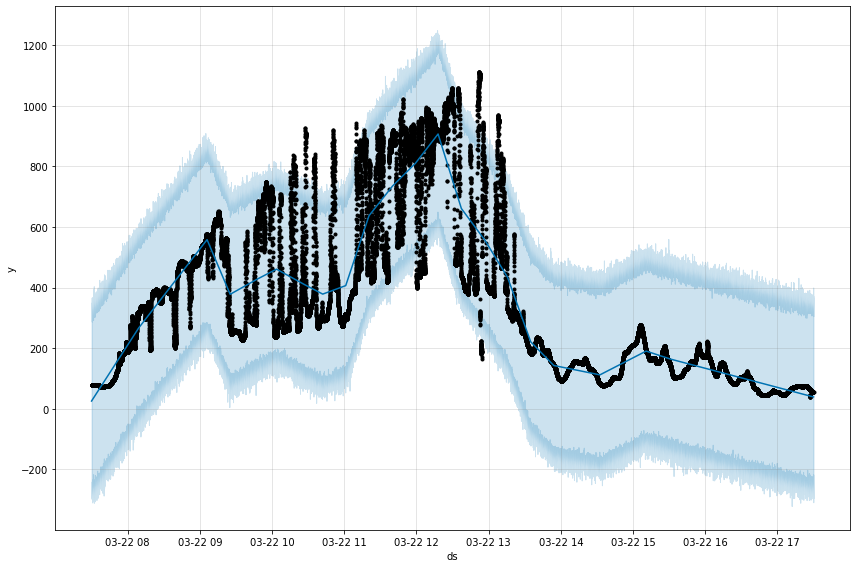

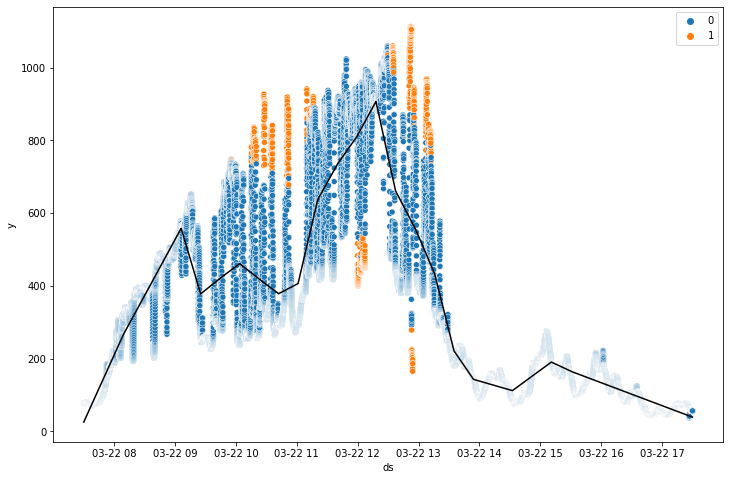

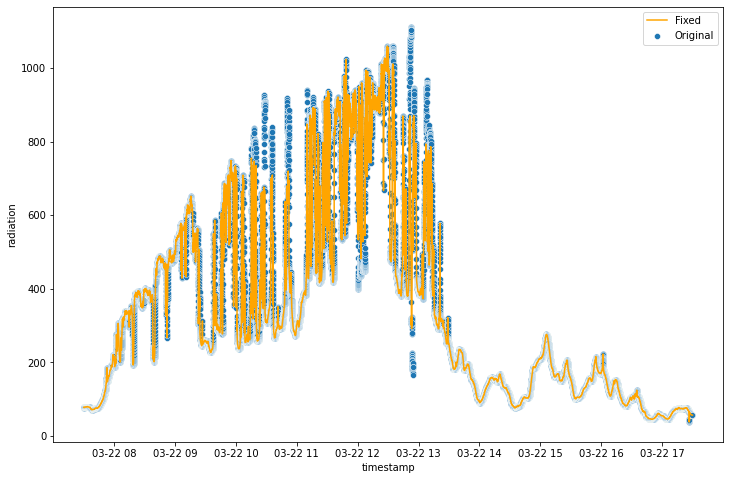

In [6]:
random.seed(1975)
coupled = SingleFarmOahu("oahu-outliers.txt", "caide/data")
coord = Coordinator(coupled)
coord.initialize()
coord.simulate_time(INFINITY)
coord.exit()

## Prediction service

Finally, we launch the prediction service repeating the process. Note that everything can be done using just one simulation file. However, we are splitting the process for simiplicity.

The simulation file to execute the prediction service is as follows. The first line transform the output of the simulation into an H5 file needed by the prediction library. Next, the inference itself is executed:

In [7]:
%%writefile caide/data/input/simulations/oahu-prediction.txt
DATETIME;COMMAND;ARGUMENTS
2010-03-22 18:00:00;CMD_TO_H5;DataCenter;Oahu;2010-03-22 07:30:00;2010-03-22 17:30:00;60;
2010-03-22 18:01:00;CMD_RUN_PREDICTION;DataCenter;Oahu;2010-03-22 07:30:00;2010-03-22 17:30:00;2010-03-22 16:00:00;510;

Writing caide/data/input/simulations/oahu-prediction.txt


We are ready now to launch the simulation:

Commander::o_cmd -> 2010-03-22 18:00:00;TO_H5


INFO:util:Commander::o_cmd -> 2010-03-22 18:00:00;TO_H5


Fog server received command to generate the H5 file with arguments: ['DataCenter', 'Oahu', '2010-03-22 07:30:00', '2010-03-22 17:30:00', '60'] ...


INFO:fog:Fog server received command to generate the H5 file with arguments: ['DataCenter', 'Oahu', '2010-03-22 07:30:00', '2010-03-22 17:30:00', '60'] ...


Commander::o_cmd -> 2010-03-22 18:01:00;RUN_PREDICTION


/usr/local/lib/python3.8/dist-packages/tables/path.py:137: NaturalNameWarning:

object name is not a valid Python identifier: '2010-03-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though

INFO:util:Commander::o_cmd -> 2010-03-22 18:01:00;RUN_PREDICTION


Fog server received command to generate prediction with arguments: ['DataCenter', 'Oahu', '2010-03-22 07:30:00', '2010-03-22 17:30:00', '2010-03-22 16:00:00', '510'] ...


INFO:fog:Fog server received command to generate prediction with arguments: ['DataCenter', 'Oahu', '2010-03-22 07:30:00', '2010-03-22 17:30:00', '2010-03-22 16:00:00', '510'] ...
DEBUG:util:FarmReportService::generate_prediction_report()


Unable to forecast at times before 07:40 and after 16:29
Prediction successful! it took 00:00:20 in total


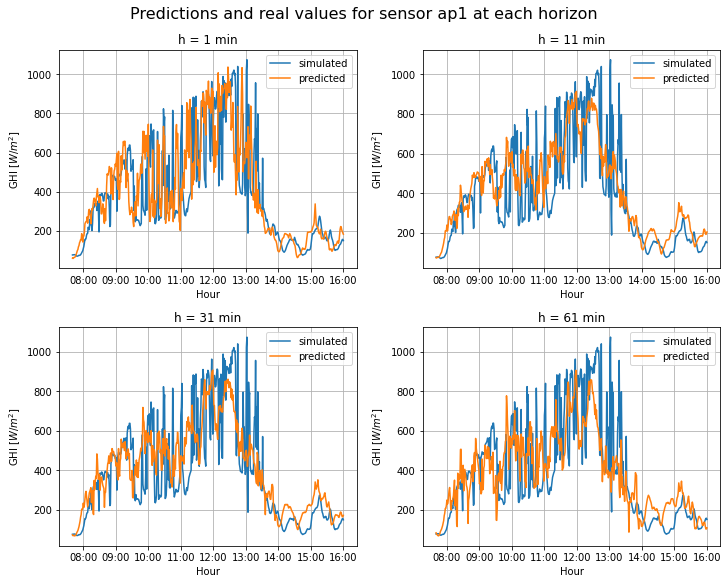

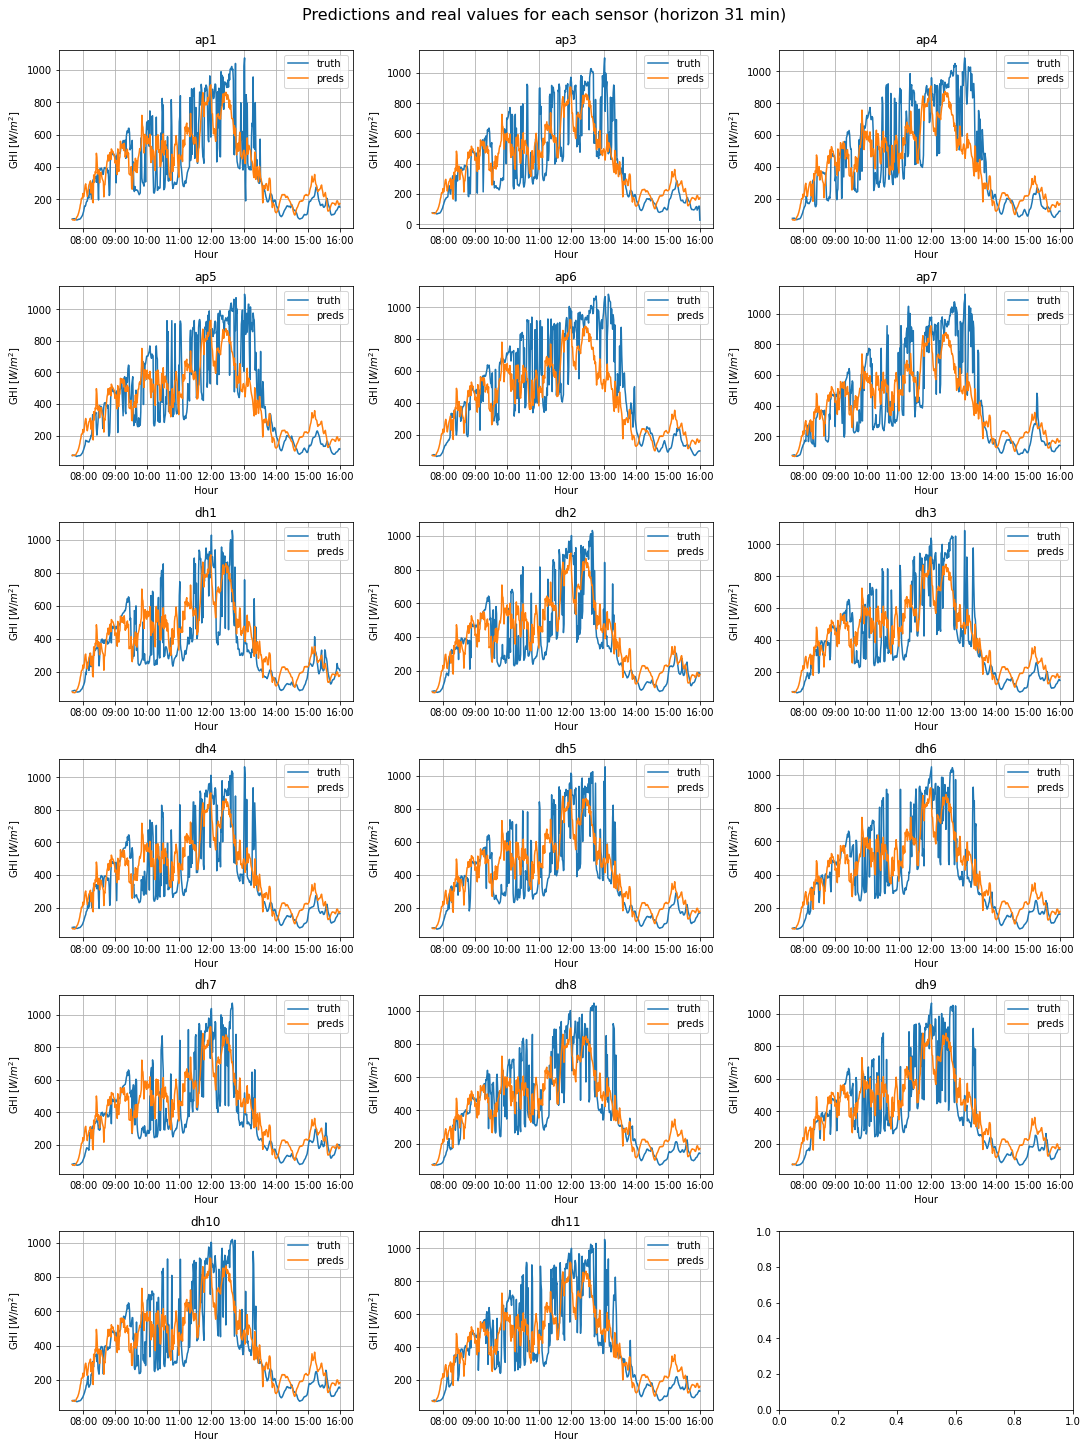

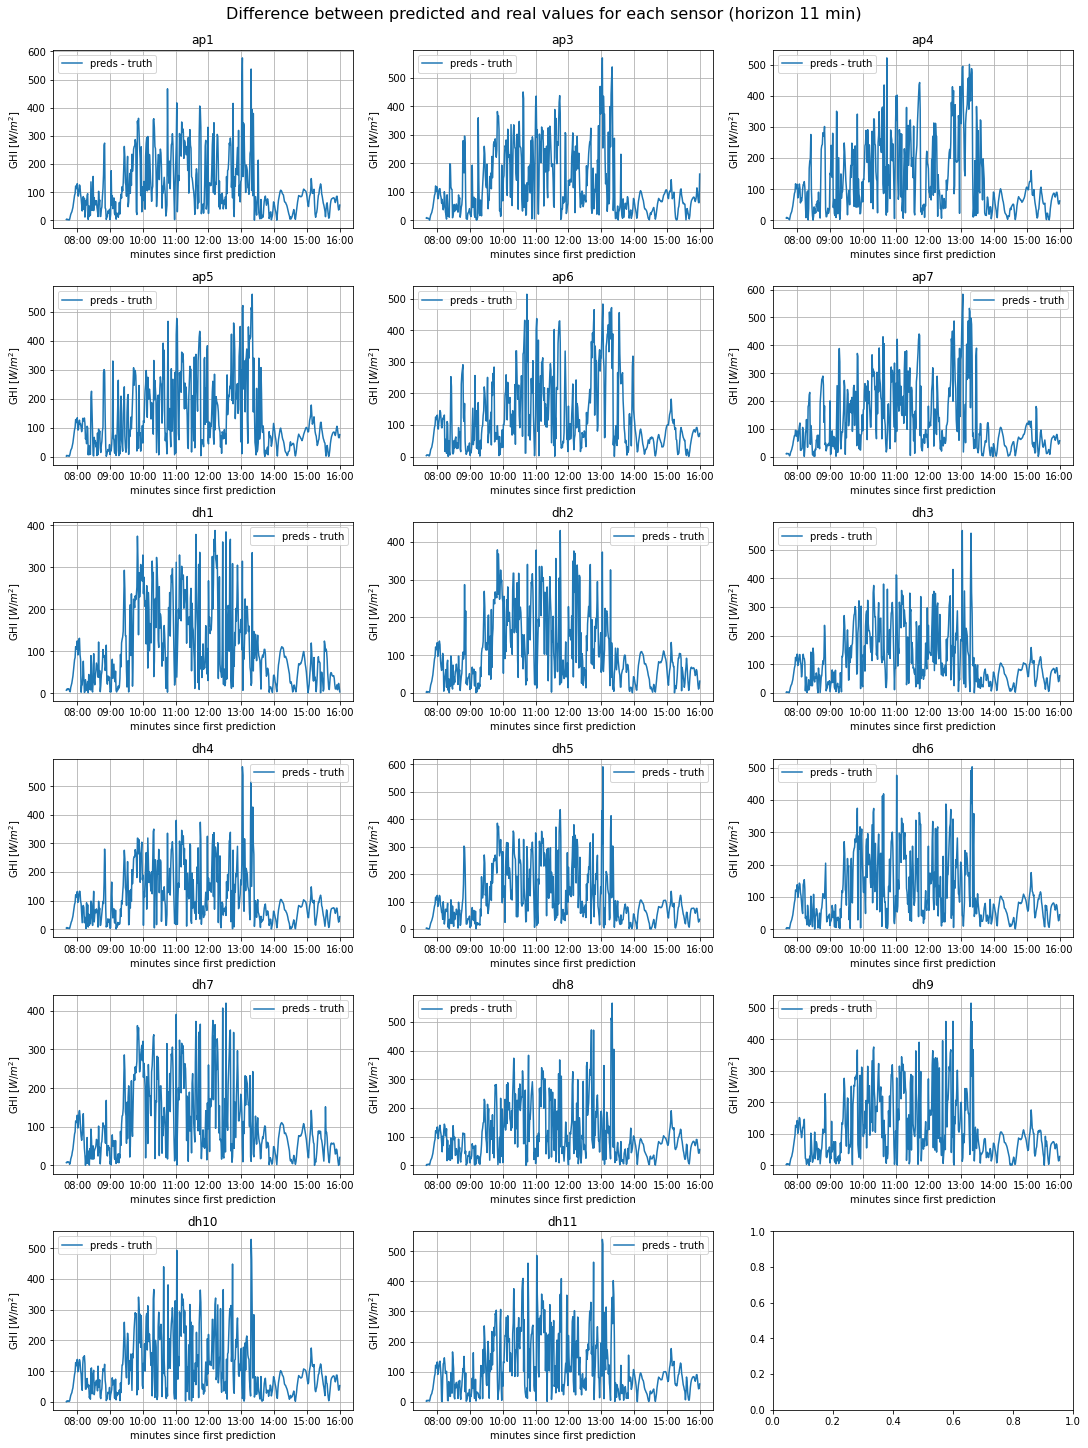

In [8]:
random.seed(1975)
coupled = SingleFarmOahu("oahu-prediction.txt", "caide/data")
coord = Coordinator(coupled)
coord.initialize()
coord.simulate_time(INFINITY)
coord.exit()